# Halo Occupation Distribution from extragalactic catalogs

> Notebook owner: Yao-Yuan Mao [@yymao](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@yymao). Last run: Nov 30, 2018

In this notebook we demostrate how to plot the halo occupation distribution of the protoDC2/cosmoDC2 galaxy catalog.

## Learning objectives
- Use `GCRCatalogs` to access the protoDC2 or cosmoDC2 catalogs. 
- Access cosmology in the extragalactic catalogs.
- Use `CCL` to predict Halo Mass Function.

In [1]:
import GCRCatalogs

In [2]:
import pyccl as ccl

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [5]:
zmax = 0.25
mass_bins = np.logspace(10, 15, 21)
mass_center = np.sqrt(mass_bins[1:] * mass_bins[:-1])

In [6]:
data = gc.get_quantities(['halo_mass', 'Mag_true_r_lsst_z0', 'redshift'], filters=['redshift < {}'.format(zmax)])

In [7]:
cosmo = ccl.Cosmology(
    Omega_c=gc.cosmology.Om0-gc.cosmology.Ob0, 
    Omega_b=gc.cosmology.Ob0, 
    h=gc.cosmology.h, 
    sigma8=gc.cosmology.sigma8, 
    n_s=gc.cosmology.n_s, 
    transfer_function='bbks',
)

In [8]:
# approximate hmf using mean redshift
mean_scale_factor = 1.0/(1.0+data['redshift'].mean())
hmf_dn_dlogm = ccl.massfunc(cosmo, mass_center, mean_scale_factor)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/pyccl/pyutils.py:407: CCLWarning: The function massfunc is deprecated. Use MassFunc instead.
  warnings.warn(s, CCLWarning)


In [9]:
d = gc.cosmology.comoving_distance(zmax).to('Mpc').value
volume = np.deg2rad(np.deg2rad(gc.sky_area)) * d**3 / 3.0

In [10]:
dlogm = np.ediff1d(np.log10(mass_bins))
nhalo_expected = hmf_dn_dlogm * volume * dlogm

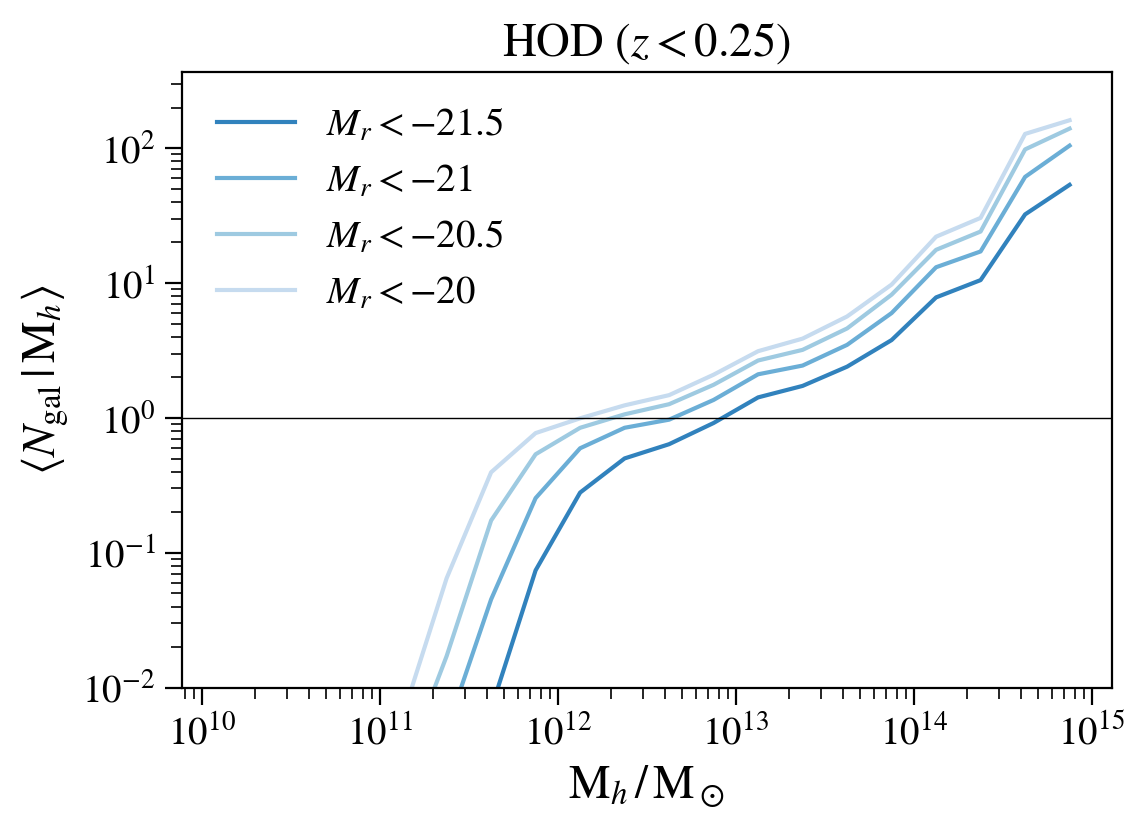

In [11]:
for Mr_thres, color in zip((-21.5, -21, -20.5, -20), plt.cm.tab20c.colors):
    plt.loglog(
        mass_center, 
        np.histogram(data['halo_mass'][data['Mag_true_r_lsst_z0'] < Mr_thres], mass_bins)[0] / nhalo_expected,
        label=r'$M_r < {}$'.format(Mr_thres),
        c=color,
    );

plt.xlabel(r'${\rm M}_h \,/\, {\rm M}_\odot$');
plt.ylabel(r'$\langle N_{\rm gal} \,|\, {\rm M}_h \rangle$');
plt.title(r'HOD $(z < 0.25)$');
plt.ylim(0.01, None)
plt.axhline(1, lw=0.5, c='k');
plt.legend();